In [1]:
# Notes
#sim_20240209_090201

In [2]:
import os
import json
from collections import namedtuple
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering

In [3]:
from utils.dataset import CarlaH5Dataset
from models.cone_model import ConstructEgo

In [4]:
def load_model(args, model_config, num_other_agents, pred_horizon):
    if torch.cuda.is_available() and not args.disable_cuda:
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    autobot_model = ConstructEgo(k_attr=model_config.k_attr,
                                   d_k=model_config.hidden_size,
                                   _M=num_other_agents,
                                   c=model_config.num_modes,
                                   T=pred_horizon,
                                   L_enc=model_config.num_encoder_layers,
                                   dropout=model_config.dropout,
                                   num_heads=model_config.tx_num_heads,
                                   L_dec=model_config.num_decoder_layers,
                                   tx_hidden_size=model_config.tx_hidden_size,
                                   map_attr=model_config.map_attr,
                                   construction_attention=model_config.construction_attention,
                                   sequence_attention=model_config.sequence_attention,
                                   baseline=model_config.baseline).to(device)

    model_dicts = torch.load(args.models_path, map_location={'cuda:1': 'cuda:0'})
    autobot_model.load_state_dict(model_dicts["AutoBot"])
    autobot_model.eval()

    return autobot_model, device

def recompute_probs(pred_trajs, probs):
    distances = []
    for k in range(len(pred_trajs)):
        distances.append(np.mean(np.linalg.norm(pred_trajs[k] - pred_trajs, axis=-1), axis=-1))
    distances = np.array(distances)

    agg = AgglomerativeClustering(affinity='precomputed', linkage='complete', distance_threshold=None, n_clusters=6)
    output = agg.fit_predict(distances)  # Returns class labels.
    temp_probs = probs.copy()
    for element in np.unique(output):
        similar_ks = np.where(output == element)[0].tolist()
        if len(similar_ks) > 1:
            best_k = similar_ks[np.argmax(temp_probs[similar_ks])]
            similar_ks.remove(best_k)
            for similar_k in similar_ks:
                temp_probs[best_k] += temp_probs[similar_k]
                temp_probs[similar_k] = 0.0

    return temp_probs

In [5]:
def load_config(model_path):
    model_dirname = os.path.join(*model_path.split("/")[:-1])
    assert os.path.isdir(model_dirname)
    with open(os.path.join(model_dirname, 'config.json'), 'r') as fp:
        config = json.load(fp)
    return config, model_dirname

In [6]:
class Args:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [7]:
def get_plot_info(ego_in, ego_out, roads, constr, pred_seqs):
    ego_in_x_points = []
    ego_in_y_points = []

    ego_out_x_points = []
    ego_out_y_points = []

    map_x_points = []
    map_y_points = []

    objects_x_points = []
    objects_y_points = []
    objects_rad_points = []

    pred_x_points = []
    pred_y_points = []

    for batch_index in range(ego_in.shape[0]):
        ego_in_x = [ego_in_i[0] for ego_in_i in ego_in[batch_index]]
        ego_in_y = [ego_in_i[1] for ego_in_i in ego_in[batch_index]]
        ego_in_x_points.append(ego_in_x)
        ego_in_y_points.append(ego_in_y)

        ego_out_x = [ego_out_i[0] for ego_out_i in ego_out[batch_index]]
        ego_out_y = [ego_out_i[1] for ego_out_i in ego_out[batch_index]]
        ego_out_x_points.append(ego_out_x)
        ego_out_y_points.append(ego_out_y)

        roads_np_batch = roads[batch_index]
        cons_np_batch = constr[batch_index]

        roads_pts = roads_np_batch[roads_np_batch[:,:, -1] == 1]
        cons_pts = cons_np_batch[cons_np_batch[:,:, -1] == 1]

        map_x = [point[0] for point in roads_pts]
        map_y = [point[1] for point in roads_pts]

        objects_x = [point[0] for point in cons_pts]
        objects_y = [point[1] for point in cons_pts]
        
        objects_rad = [np.max([point[2], point[3]]) for point in cons_pts]

        map_x_points.append(map_x)
        map_y_points.append(map_y)

        objects_x_points.append(objects_x)
        objects_y_points.append(objects_y)
        objects_rad_points.append(objects_rad)

        # Predictions
        mode_points_x = []
        mode_points_y = []
        
        for mode in range(10):
            pred_x = [pred_i[0] for pred_i in pred_seqs[batch_index, mode]]
            pred_y = [pred_i[1] for pred_i in pred_seqs[batch_index, mode]]
            mode_points_x.append(pred_x)
            mode_points_y.append(pred_y)
        pred_x_points.append(mode_points_x)
        pred_y_points.append(mode_points_y)
    return ego_in_x_points, ego_in_y_points, ego_out_x_points, ego_out_y_points, \
               map_x_points, map_y_points, objects_rad_points, objects_x_points, \
                    objects_y_points, pred_x_points, pred_y_points

In [8]:
dataset_path = "/home/juan/Documents/simulators/cone_sim/dataset/" 
batch_size = 100
disable_cuda = False

In [9]:
# Autobot_ego_C10_H128_E2_D2_TXH384_NH16_EW40_KLW20_NormLoss_construction_corrected_s1
# Autobot_ego_C10_H128_E2_D2_TXH384_NH16_EW40_KLW20_NormLoss_n0_construction_corrected_s1

In [10]:
#models_path = "../results/carla/prev/Cone_ego_C10_H128_E2_D2_TXH384_NH16_EW40_KLW20_NormLoss_xy_autobots_s1/best_models_ade.pth"
models_path = "../results/carla/prev/Cone_ego_C10_H128_E2_D2_TXH384_NH16_EW40_KLW20_NormLoss_xy_attention_s1/best_models_ade.pth"
#models_path = "../results/carla/Cone_ego_C10_H128_E2_D2_TXH384_NH16_EW40_KLW20_NormLoss_xywl_attention_s1/best_models_ade.pth"

In [11]:
#models_path = "../results/carla/Cone_ego_C10_H128_E2_D2_TXH384_NH16_EW40_KLW20_NormLoss_xy_attention_seq_s1/best_models_ade.pth"
#models_path = "../results/carla/Cone_ego_C10_H128_E2_D2_TXH384_NH16_EW40_KLW20_NormLoss_xy_baseline_2.0_s1/best_models_ade.pth"
#models_path = "../results/carla/Cone_ego_C10_H128_E2_D2_TXH384_NH16_EW40_KLW20_NormLoss_xy_seq_attention_2.0_s1/best_models_ade.pth"

In [12]:
dataset_info = Args(map_attr = 6,
                    k_attr = 5)

In [13]:
args = {"disable_cuda" : disable_cuda, 
        "dataset_path" : dataset_path,
        "models_path" : models_path,
        "batch_size" : batch_size}

In [14]:
args = namedtuple("args",  args.keys())(*args.values())

In [15]:
model_config = Args(exp_id="____",
                    disable_cuda=False, 
                    seed=1, 
                    learning_rate=0.00075,
                    adam_epsilon=1e-4,
                    learning_rate_sched=[10, 20, 30, 40, 50],
                    dataset="carla",
                    save_dir="/home/juan/Documents/simulators/cone_sim/",
                    dataset_path="/home/juan/Documents/simulators/cone_sim/dataset/",
                    model_type="Cone-Ego",
                    batch_size=64,
                    hidden_size=128,
                    num_modes=10,
                    num_encoder_layers=2,
                    dropout=0.1,
                    tx_num_heads=16,
                    num_decoder_layers=2,
                    tx_hidden_size=384,
                    num_epochs=150,
                    entropy_weight=40.0,
                    kl_weight=20.0,
                    use_FDEADE_aux_loss=True,
                    grad_clip_norm = 5.0,
                    map_attr = 3, #5,
                    k_attr = 2, #4,
                    construction_attention=True, 
                    sequence_attention= True,
                    #baseline= False
                    baseline= True
                    )

In [16]:
val_dset = CarlaH5Dataset(dset_path=dataset_path, k_attr=dataset_info.k_attr,
                          map_attr=dataset_info.map_attr, split_name="val")

val_loader = torch.utils.data.DataLoader(
    val_dset, batch_size=batch_size, shuffle=False, num_workers=12, drop_last=False, pin_memory=False
)
print("Val dataset loaded with length", len(val_dset))

Val dataset loaded with length 33976


In [17]:
train_dset = CarlaH5Dataset(dset_path=dataset_path, k_attr=dataset_info.k_attr,
                          map_attr=dataset_info.map_attr, split_name="train")

train_loader = torch.utils.data.DataLoader(
    train_dset, batch_size=batch_size, shuffle=False, num_workers=12, drop_last=False, pin_memory=False
)
print("Train dataset loaded with length", len(train_dset))

Train dataset loaded with length 138282


In [18]:
for i, data in enumerate(val_loader):
    ego_in, ego_out, roads, constr = data
    if i == 0:
        break

In [19]:
constr.shape

torch.Size([100, 50, 1, 7])

In [20]:
val_dset.map_attr

6

In [21]:
autobot_model, device = load_model(args, model_config, val_dset.num_others, val_dset.pred_horizon)

CONFIGS
baseline: True
construction_attention: True
sequence_attention: True
k_attr: 2
map_attr: 3


In [22]:
device

device(type='cuda')

In [23]:
preds = []
with torch.no_grad():
    ego_in = ego_in.float().to(device)
    ego_out_t = ego_out.float().to(device)
    roads = roads.float().to(device)
    constr = constr.float().to(device)

    pred_obs, mode_preds = autobot_model(ego_in, roads, constr)
    pred_seqs = pred_obs[:, :, :, :2].cpu().numpy().transpose((2, 0, 1, 3))
    mode_preds = mode_preds.cpu().numpy()

In [24]:
ego_in = ego_in.cpu().numpy()
ego_out = ego_out_t.cpu().numpy()
roads = roads.float().cpu().numpy()
constr = constr.float().cpu().numpy()

In [25]:
ego_in.shape

(100, 4, 7)

In [26]:
ego_out.shape

(100, 12, 7)

In [27]:
roads.shape

(100, 100, 40, 7)

In [28]:
constr.shape

(100, 50, 1, 7)

In [29]:
ego_in_x_points, ego_in_y_points, ego_out_x_points, \
    ego_out_y_points, map_x_points, map_y_points, objects_rad_points, \
        objects_x_points, objects_y_points, \
            pred_x_points, pred_y_points = get_plot_info(ego_in, ego_out, roads, constr, pred_seqs)

In [49]:
#index = 79 #i=2
#index = 60 #i=5
#index = 60 #i=6
#index = 18 #i=7
index =17#i=7

In [50]:
areas = np.pi * (np.array(objects_rad_points[index]) / 2)**2
areas

array([0.0995142 , 0.1868792 , 0.43149278, 0.74602103, 0.9195376 ,
       1.0984448 , 1.0606788 , 1.3389144 , 0.98884916, 0.98884916,
       0.90630704, 0.90630704, 0.8148142 , 0.8148142 , 0.7186193 ,
       0.7186193 , 0.62025857, 0.62025857, 0.6107528 , 0.6107528 ,
       0.6107528 , 0.6107528 , 0.6107528 , 0.6107528 , 0.6107528 ,
       1.3389144 , 1.3389144 , 1.3389144 , 1.1703345 , 1.1703345 ,
       1.1703345 , 1.122155  , 1.122155  , 1.0606788 , 1.3389144 ,
       0.2982282 , 1.2775453 , 0.6107528 , 0.6107528 , 0.6107528 ,
       0.6107528 ], dtype=float32)

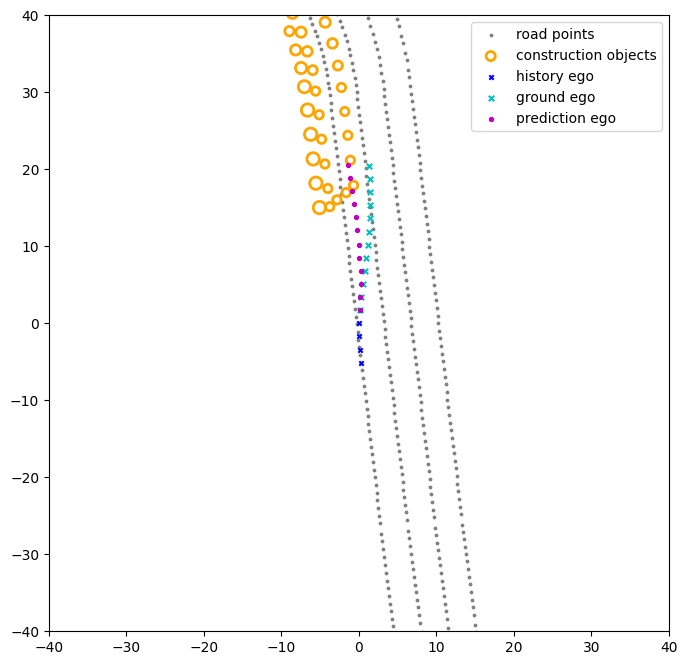

In [51]:
mode = 0

plt.figure(figsize=(8,8))
plt.scatter(map_x_points[index], map_y_points[index], s=3, color="gray", label="road points")
plt.scatter(objects_x_points[index], objects_y_points[index], s=areas*60, facecolors='none', 
            edgecolors="orange", label="construction objects", linewidths=2)
plt.scatter(ego_in_x_points[index], ego_in_y_points[index], s=10, color="b", marker="x", label="history ego")
#plt.scatter(agents_in_x_points[index], agents_in_y_points[index], s=15, color="r", marker="x", label="history other agents")
plt.scatter(ego_out_x_points[index], ego_out_y_points[index], s=15, color="c", marker="x", label="ground ego")
#plt.scatter(pred_x_points[index][mode][:4], pred_y_points[index][mode][:4], s=8, color="m", label="prediction ego")
plt.scatter(pred_x_points[index][mode], pred_y_points[index][mode], s=8, color="m", label="prediction ego")

plt.xlim(-40,40)
plt.ylim(-40,40)
plt.legend()

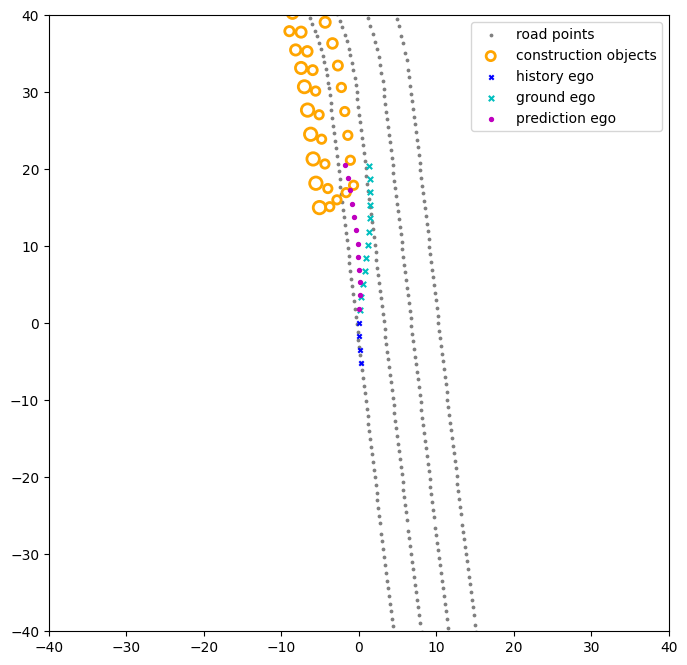

In [52]:
mode = 1

plt.figure(figsize=(8,8))
plt.scatter(map_x_points[index], map_y_points[index], s=3, color="gray", label="road points")
plt.scatter(objects_x_points[index], objects_y_points[index], s=areas*60, facecolors='none', 
            edgecolors="orange", label="construction objects", linewidths=2)
plt.scatter(ego_in_x_points[index], ego_in_y_points[index], s=10, color="b", marker="x", label="history ego")
#plt.scatter(agents_in_x_points[index], agents_in_y_points[index], s=15, color="r", marker="x", label="history other agents")
plt.scatter(ego_out_x_points[index], ego_out_y_points[index], s=15, color="c", marker="x", label="ground ego")
#plt.scatter(pred_x_points[index][mode][:4], pred_y_points[index][mode][:4], s=8, color="m", label="prediction ego")
plt.scatter(pred_x_points[index][mode], pred_y_points[index][mode], s=8, color="m", label="prediction ego")

plt.xlim(-40,40)
plt.ylim(-40,40)
plt.legend()

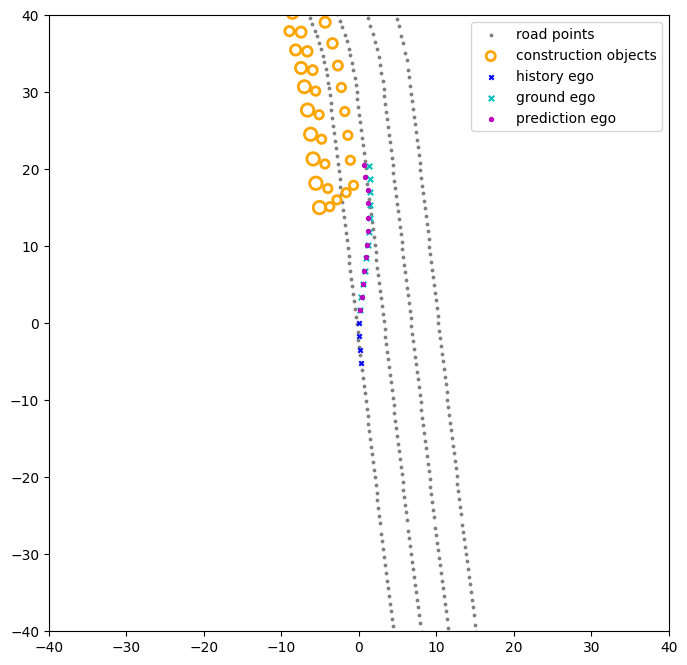

In [53]:
mode = 2

plt.figure(figsize=(8,8))
plt.scatter(map_x_points[index], map_y_points[index], s=3, color="gray", label="road points")
plt.scatter(objects_x_points[index], objects_y_points[index], s=areas*60, facecolors='none', 
            edgecolors="orange", label="construction objects", linewidths=2)
plt.scatter(ego_in_x_points[index], ego_in_y_points[index], s=10, color="b", marker="x", label="history ego")
#plt.scatter(agents_in_x_points[index], agents_in_y_points[index], s=15, color="r", marker="x", label="history other agents")
plt.scatter(ego_out_x_points[index], ego_out_y_points[index], s=15, color="c", marker="x", label="ground ego")
#plt.scatter(pred_x_points[index][mode][:4], pred_y_points[index][mode][:4], s=8, color="m", label="prediction ego")
plt.scatter(pred_x_points[index][mode], pred_y_points[index][mode], s=8, color="m", label="prediction ego")

plt.xlim(-40,40)
plt.ylim(-40,40)
plt.legend()

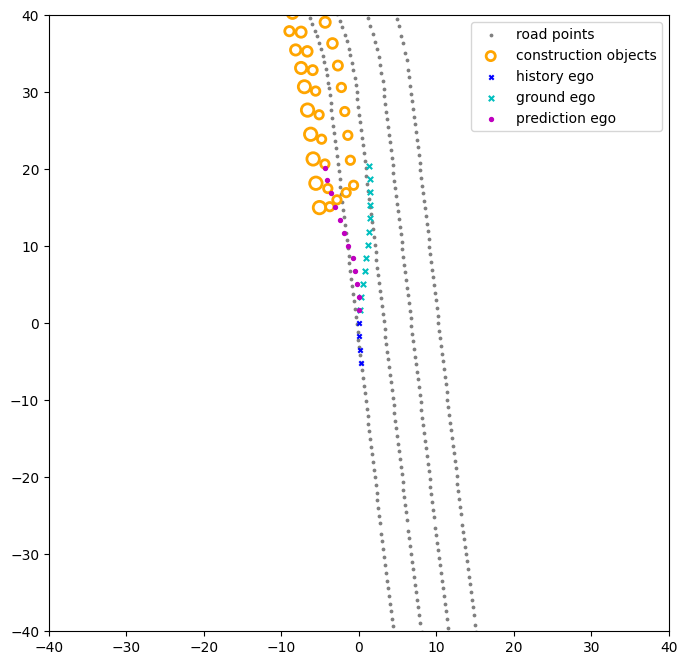

In [54]:
mode = 3

plt.figure(figsize=(8,8))
plt.scatter(map_x_points[index], map_y_points[index], s=3, color="gray", label="road points")
plt.scatter(objects_x_points[index], objects_y_points[index], s=areas*60, facecolors='none', 
            edgecolors="orange", label="construction objects", linewidths=2)
plt.scatter(ego_in_x_points[index], ego_in_y_points[index], s=10, color="b", marker="x", label="history ego")
#plt.scatter(agents_in_x_points[index], agents_in_y_points[index], s=15, color="r", marker="x", label="history other agents")
plt.scatter(ego_out_x_points[index], ego_out_y_points[index], s=15, color="c", marker="x", label="ground ego")
#plt.scatter(pred_x_points[index][mode][:4], pred_y_points[index][mode][:4], s=8, color="m", label="prediction ego")
plt.scatter(pred_x_points[index][mode], pred_y_points[index][mode], s=8, color="m", label="prediction ego")

plt.xlim(-40,40)
plt.ylim(-40,40)
plt.legend()

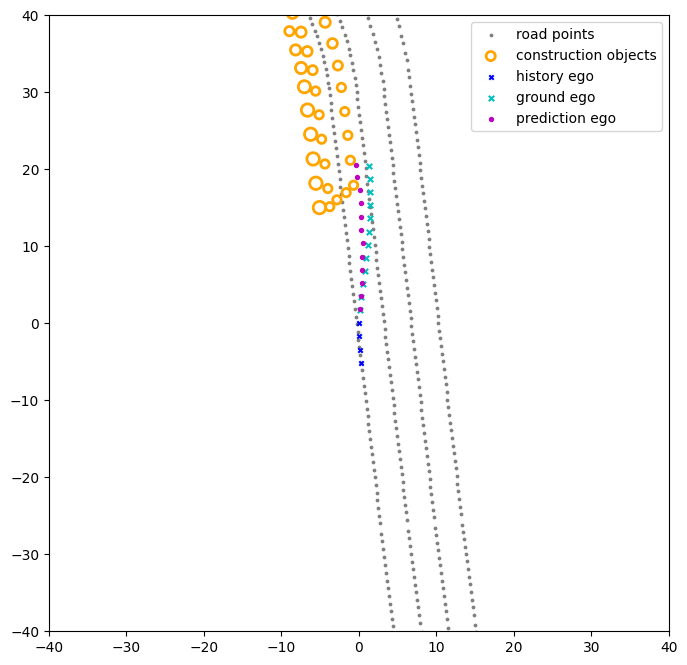

In [55]:
mode = 4

plt.figure(figsize=(8,8))
plt.scatter(map_x_points[index], map_y_points[index], s=3, color="gray", label="road points")
plt.scatter(objects_x_points[index], objects_y_points[index], s=areas*60, facecolors='none', 
            edgecolors="orange", label="construction objects", linewidths=2)
plt.scatter(ego_in_x_points[index], ego_in_y_points[index], s=10, color="b", marker="x", label="history ego")
#plt.scatter(agents_in_x_points[index], agents_in_y_points[index], s=15, color="r", marker="x", label="history other agents")
plt.scatter(ego_out_x_points[index], ego_out_y_points[index], s=15, color="c", marker="x", label="ground ego")
#plt.scatter(pred_x_points[index][mode][:4], pred_y_points[index][mode][:4], s=8, color="m", label="prediction ego")
plt.scatter(pred_x_points[index][mode], pred_y_points[index][mode], s=8, color="m", label="prediction ego")

plt.xlim(-40,40)
plt.ylim(-40,40)
plt.legend()

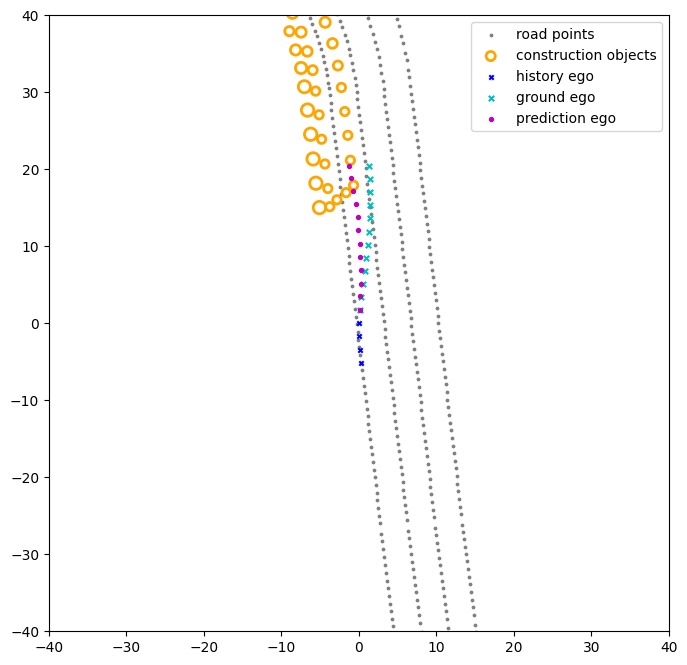

In [56]:
mode = 5

plt.figure(figsize=(8,8))
plt.scatter(map_x_points[index], map_y_points[index], s=3, color="gray", label="road points")
plt.scatter(objects_x_points[index], objects_y_points[index], s=areas*60, facecolors='none', 
            edgecolors="orange", label="construction objects", linewidths=2)
plt.scatter(ego_in_x_points[index], ego_in_y_points[index], s=10, color="b", marker="x", label="history ego")
#plt.scatter(agents_in_x_points[index], agents_in_y_points[index], s=15, color="r", marker="x", label="history other agents")
plt.scatter(ego_out_x_points[index], ego_out_y_points[index], s=15, color="c", marker="x", label="ground ego")
#plt.scatter(pred_x_points[index][mode][:4], pred_y_points[index][mode][:4], s=8, color="m", label="prediction ego")
plt.scatter(pred_x_points[index][mode], pred_y_points[index][mode], s=8, color="m", label="prediction ego")

plt.xlim(-40,40)
plt.ylim(-40,40)
plt.legend()

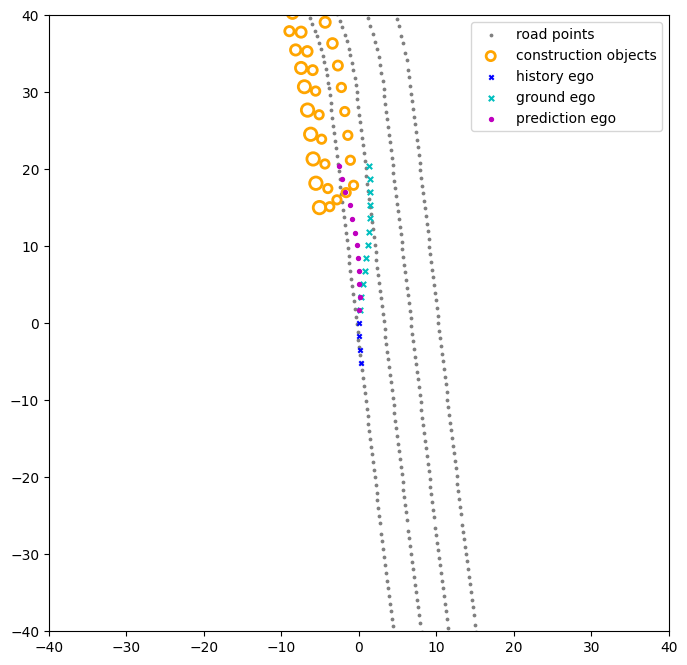

In [57]:
mode = 6

plt.figure(figsize=(8,8))
plt.scatter(map_x_points[index], map_y_points[index], s=3, color="gray", label="road points")
plt.scatter(objects_x_points[index], objects_y_points[index], s=areas*60, facecolors='none', 
            edgecolors="orange", label="construction objects", linewidths=2)
plt.scatter(ego_in_x_points[index], ego_in_y_points[index], s=10, color="b", marker="x", label="history ego")
#plt.scatter(agents_in_x_points[index], agents_in_y_points[index], s=15, color="r", marker="x", label="history other agents")
plt.scatter(ego_out_x_points[index], ego_out_y_points[index], s=15, color="c", marker="x", label="ground ego")
#plt.scatter(pred_x_points[index][mode][:4], pred_y_points[index][mode][:4], s=8, color="m", label="prediction ego")
plt.scatter(pred_x_points[index][mode], pred_y_points[index][mode], s=8, color="m", label="prediction ego")

plt.xlim(-40,40)
plt.ylim(-40,40)
plt.legend()

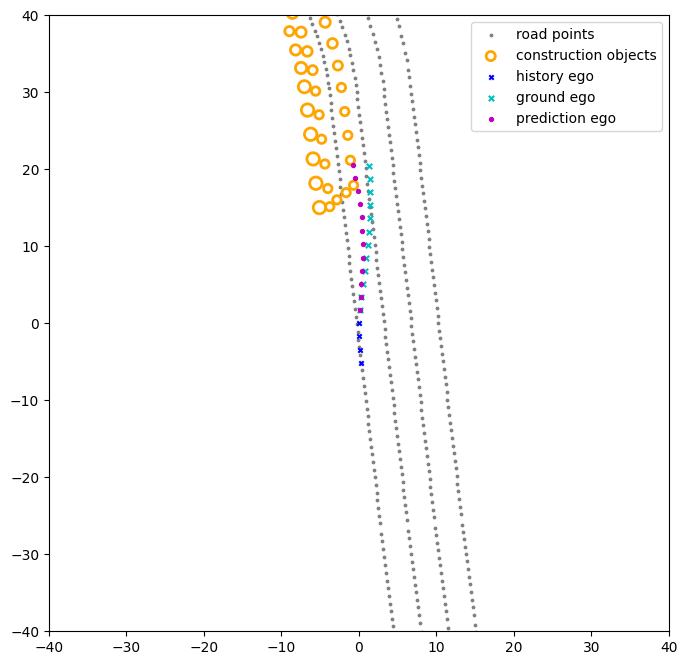

In [58]:
mode = 7

plt.figure(figsize=(8,8))
plt.scatter(map_x_points[index], map_y_points[index], s=3, color="gray", label="road points")
plt.scatter(objects_x_points[index], objects_y_points[index], s=areas*60, facecolors='none', 
            edgecolors="orange", label="construction objects", linewidths=2)
plt.scatter(ego_in_x_points[index], ego_in_y_points[index], s=10, color="b", marker="x", label="history ego")
#plt.scatter(agents_in_x_points[index], agents_in_y_points[index], s=15, color="r", marker="x", label="history other agents")
plt.scatter(ego_out_x_points[index], ego_out_y_points[index], s=15, color="c", marker="x", label="ground ego")
#plt.scatter(pred_x_points[index][mode][:4], pred_y_points[index][mode][:4], s=8, color="m", label="prediction ego")
plt.scatter(pred_x_points[index][mode], pred_y_points[index][mode], s=8, color="m", label="prediction ego")

plt.xlim(-40,40)
plt.ylim(-40,40)
plt.legend()

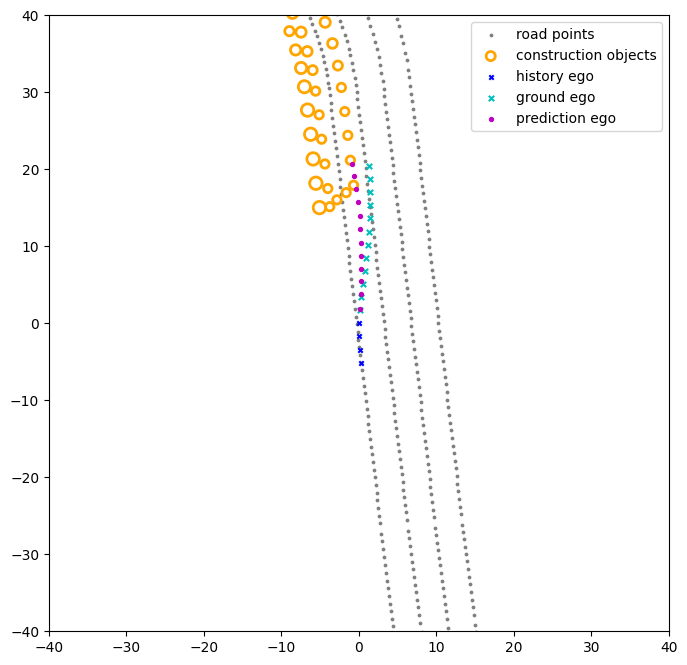

In [59]:
mode = 8

plt.figure(figsize=(8,8))
plt.scatter(map_x_points[index], map_y_points[index], s=3, color="gray", label="road points")
plt.scatter(objects_x_points[index], objects_y_points[index], s=areas*60, facecolors='none', 
            edgecolors="orange", label="construction objects", linewidths=2)
plt.scatter(ego_in_x_points[index], ego_in_y_points[index], s=10, color="b", marker="x", label="history ego")
#plt.scatter(agents_in_x_points[index], agents_in_y_points[index], s=15, color="r", marker="x", label="history other agents")
plt.scatter(ego_out_x_points[index], ego_out_y_points[index], s=15, color="c", marker="x", label="ground ego")
#plt.scatter(pred_x_points[index][mode][:4], pred_y_points[index][mode][:4], s=8, color="m", label="prediction ego")
plt.scatter(pred_x_points[index][mode], pred_y_points[index][mode], s=8, color="m", label="prediction ego")

plt.xlim(-40,40)
plt.ylim(-40,40)
plt.legend()

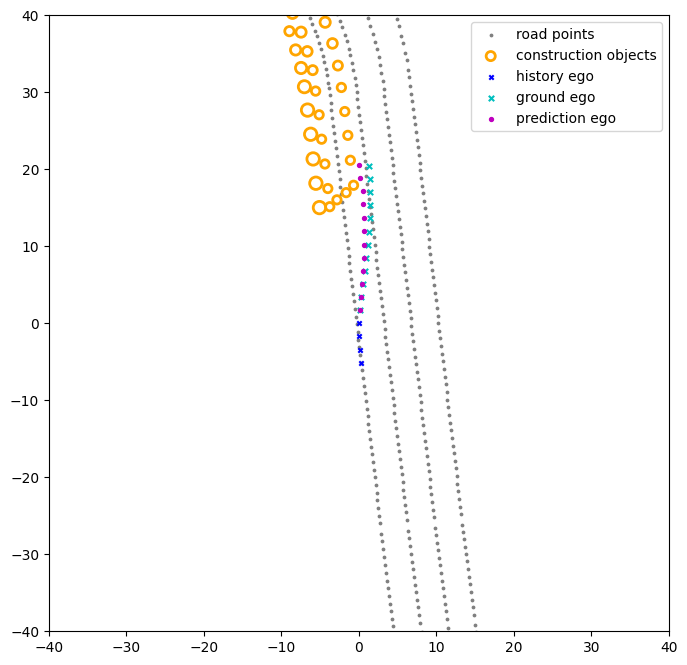

In [60]:
mode = 9

plt.figure(figsize=(8,8))
plt.scatter(map_x_points[index], map_y_points[index], s=3, color="gray", label="road points")
plt.scatter(objects_x_points[index], objects_y_points[index], s=areas*60, facecolors='none', 
            edgecolors="orange", label="construction objects", linewidths=2)
plt.scatter(ego_in_x_points[index], ego_in_y_points[index], s=10, color="b", marker="x", label="history ego")
#plt.scatter(agents_in_x_points[index], agents_in_y_points[index], s=15, color="r", marker="x", label="history other agents")
plt.scatter(ego_out_x_points[index], ego_out_y_points[index], s=15, color="c", marker="x", label="ground ego")
#plt.scatter(pred_x_points[index][mode][:4], pred_y_points[index][mode][:4], s=8, color="m", label="prediction ego")
plt.scatter(pred_x_points[index][mode], pred_y_points[index][mode], s=8, color="m", label="prediction ego")

plt.xlim(-40,40)
plt.ylim(-40,40)
plt.legend()

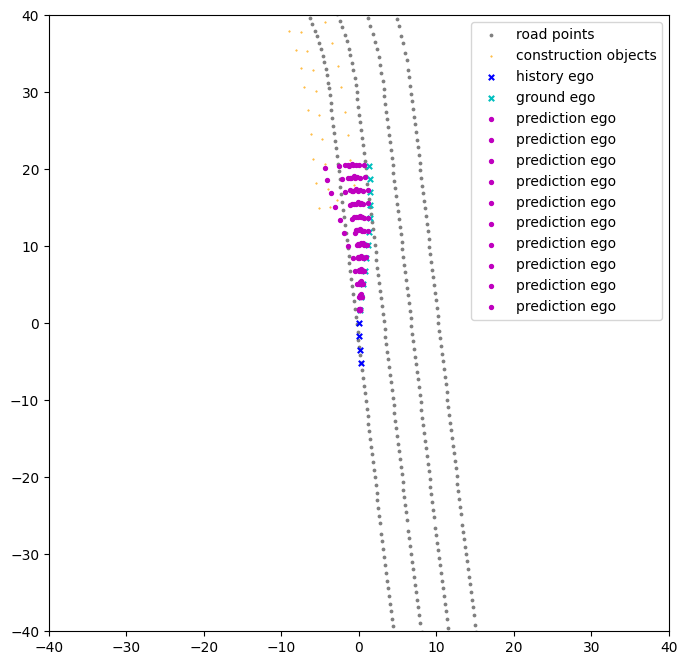

In [61]:
plt.figure(figsize=(8,8))
plt.scatter(map_x_points[index], map_y_points[index], s=3, color="gray", label="road points")
plt.scatter(objects_x_points[index], objects_y_points[index], s=0.2, color="orange", label="construction objects")
plt.scatter(ego_in_x_points[index], ego_in_y_points[index], s=15, color="b", marker="x", label="history ego")
#plt.scatter(agents_in_x_points[index], agents_in_y_points[index], s=15, color="r", marker="x", label="history other agents")
plt.scatter(ego_out_x_points[index], ego_out_y_points[index], s=15, color="c", marker="x", label="ground ego")

plt.scatter(pred_x_points[index][0], pred_y_points[index][0], s=8, color="m", label="prediction ego")
plt.scatter(pred_x_points[index][1], pred_y_points[index][1], s=8, color="m", label="prediction ego")
plt.scatter(pred_x_points[index][2], pred_y_points[index][2], s=8, color="m", label="prediction ego")
plt.scatter(pred_x_points[index][3], pred_y_points[index][3], s=8, color="m", label="prediction ego")
plt.scatter(pred_x_points[index][4], pred_y_points[index][4], s=8, color="m", label="prediction ego")
plt.scatter(pred_x_points[index][5], pred_y_points[index][5], s=8, color="m", label="prediction ego")
plt.scatter(pred_x_points[index][6], pred_y_points[index][6], s=8, color="m", label="prediction ego")
plt.scatter(pred_x_points[index][7], pred_y_points[index][7], s=8, color="m", label="prediction ego")
plt.scatter(pred_x_points[index][8], pred_y_points[index][8], s=8, color="m", label="prediction ego")
plt.scatter(pred_x_points[index][9], pred_y_points[index][9], s=8, color="m", label="prediction ego")

plt.xlim(-40,40)
plt.ylim(-40,40)
plt.legend()

In [62]:
pred_seqs.shape

(100, 10, 12, 2)

In [63]:
probs_traj = recompute_probs(pred_seqs[index], mode_preds[index])
probs_traj

array([0.        , 0.        , 0.03862268, 0.03244906, 0.        ,
       0.41629845, 0.07752348, 0.35725874, 0.        , 0.07784754],
      dtype=float32)

In [64]:
def plot_trajectories_with_increased_blur_effect(trajectories, probabilities, map_points, objects_points,\
                                                 ego_in_points, ego_out_points, index, objects_width):
    # Define the colormap from a very light pinkish-magenta to a very dark magenta for enhanced contrast
    cmap = mcolors.LinearSegmentedColormap.from_list("", ["#FFD1DC", "#4B0082"])  # Light Pinkish-Magenta to Indigo
    
    # Normalize the probabilities to match the colormap scale
    norm = mcolors.Normalize(vmin=np.min(probabilities), vmax=np.max(probabilities))
    
    fig, ax = plt.subplots()
    for trajectory, prob in zip(trajectories[index], probabilities):
        # Extract x and y coordinates
        x, y = trajectory[:, 0], trajectory[:, 1]
        
        # Increasing blur effect by plotting lines with higher transparency and linewidth
        linewidth = 3 + prob * 3  # Increase linewidth based on probability for more blur
        alpha = 0.3 + prob * 0.2  # Increase transparency for more blur
        
        # Plot each trajectory segment individually to increase blur effect
        for i in range(len(x)-1):
            ax.plot(x[i:i+2], y[i:i+2], linestyle='-', color=cmap(norm(prob)), linewidth=linewidth, alpha=alpha)
        
    # Add a colorbar to indicate the mapping from color to probability
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Probability')
    
    plt.scatter(map_points[0][index], map_points[1][index], s=0.5, color="gray", label="road points")
    plt.scatter(objects_points[0][index], objects_points[1][index], s=objects_width*5, facecolors='none', 
                edgecolors="orange", label="construction objects", linewidths=1.5)
    plt.scatter(ego_in_points[0][index], ego_in_points[1][index], s=10, color="b", label="history")
    #plt.scatter(agents_in_x_points[index], agents_in_y_points[index], s=15, color="r", marker="x", label="history other agents")
    plt.scatter(ego_out_points[0][index], ego_out_points[1][index], s=10, color="c", label="ground truth")
    #plt.scatter(pred_x_points[index][mode][:4], pred_y_points[index][mode][:4], s=8, color="m", label="prediction ego")
    #plt.scatter(pred_x_points[index][mode], pred_y_points[index][mode], s=8, color="m", label="prediction ego")
    plt.xlim(-40,40)
    plt.ylim(-20,40)
    #plt.legend(loc='lower left')
    plt.legend(fontsize='small')
    
    #plt.title('Sequential Trajectories with Increased Blur Effect')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    
    ax = plt.gca()
    ax.set_aspect('equal')
    ax.set_facecolor('white')  # Set background to black for better visibility of blur effect
    plt.show()

In [65]:
import matplotlib.colors as mcolors

In [66]:
map_points = [map_x_points, map_y_points]
objects_points = [objects_x_points, objects_y_points]
ego_in_points = [ego_in_x_points, ego_in_y_points]
ego_out_points = [ego_out_x_points, ego_out_y_points]

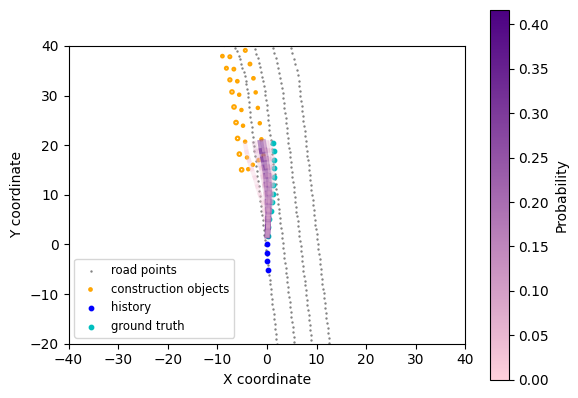

In [67]:
# Plotting the sequential trajectories with increased blur effect
plot_trajectories_with_increased_blur_effect(pred_seqs, probs_traj, map_points, objects_points,\
                                                 ego_in_points, ego_out_points, index, areas)